In [1]:
import pandas as pd
import numpy as np
import requests
import csv
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import hinge_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
import plotly.figure_factory as ff
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("health.data.ny.gov", None)

In [2]:
data = pd.read_pickle('full_data.pkl')

In [3]:
data.columns

Index(['abortion_edit_indicator', 'age_group', 'apr_drg_code',
       'apr_drg_description', 'apr_mdc_code', 'apr_mdc_description',
       'apr_medical_surgical_description', 'apr_risk_of_mortality',
       'apr_severity_of_illness_code', 'apr_severity_of_illness_description',
       'birth_weight', 'ccs_diagnosis_code', 'ccs_diagnosis_description',
       'ccs_procedure_code', 'ccs_procedure_description', 'discharge_year',
       'emergency_department_indicator', 'ethnicity', 'facility_id',
       'facility_name', 'gender', 'hospital_county', 'hospital_service_area',
       'length_of_stay', 'operating_certificate_number', 'patient_disposition',
       'race', 'source_of_payment_1', 'source_of_payment_2',
       'source_of_payment_3', 'total_charges', 'total_costs',
       'type_of_admission', 'zip_code_3_digits'],
      dtype='object')

In [29]:
##IQI Composite
iqi1 = client.get("ba3n-bkk4", limit=200000)
composite = pd.DataFrame.from_records(iqi1)

iqi_h = client.get("xyfc-qbbr", limit=200000)
iqi_hospital = pd.DataFrame.from_records(iqi_h)

iqi_p = client.get("amqp-cz9w", limit=200000)
iqi_Readmission = pd.DataFrame.from_records(iqi_p)

# Data Preprocessing and Visualization

In [5]:
data_circular = data[data['apr_mdc_description'] == 'Diseases and Disorders of the Circulatory System']
data_circular['flag'] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
for i in range(len(data_circular)): 
    if data_circular.iloc[i, 23] == '120 +':
        data_circular.iloc[i, 23] = 120 
        data_circular.iloc[i, 34] = 1 #boolean variable

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [70]:
data_circular['expect_outcome'] = 0
home = ['Home or Self Care', 'Home w/ Home Health Services', 'Left Against Medical Advice']
continue_care = ['Inpatient Rehabilitation Facility', 'Skilled Nursing Home', 'Short-term Hospital',
                 'Facility w/ Custodial/Supportive Care',
        'Medicare Cert Long Term Care Hospital', "Cancer Center or Children's Hospital", 
                 'Federal Health Care Facility', 'Medicaid Cert Nursing Facility', 'Critical Access Hospital']
hosp = ['Hospice - Home', 'Hospice - Medical Facility', 'Hosp Basd Medicare Approved Swing Bed']
other = ['Another Type Not Listed', "Court/Law Enforcement", 'Psychiatric Hospital or Unit of Hosp']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
data_circular.columns

Index(['abortion_edit_indicator', 'age_group', 'apr_drg_code',
       'apr_drg_description', 'apr_mdc_code', 'apr_mdc_description',
       'apr_medical_surgical_description', 'apr_risk_of_mortality',
       'apr_severity_of_illness_code', 'apr_severity_of_illness_description',
       'birth_weight', 'ccs_diagnosis_code', 'ccs_diagnosis_description',
       'ccs_procedure_code', 'ccs_procedure_description', 'discharge_year',
       'emergency_department_indicator', 'ethnicity', 'facility_id',
       'facility_name', 'gender', 'hospital_county', 'hospital_service_area',
       'length_of_stay', 'operating_certificate_number', 'patient_disposition',
       'race', 'source_of_payment_1', 'source_of_payment_2',
       'source_of_payment_3', 'total_charges', 'total_costs',
       'type_of_admission', 'zip_code_3_digits', 'flag'],
      dtype='object')

In [72]:
for i in range(len(data_circular)):
    if data_circular.iloc[i, 25] in home:
        data_circular.iloc[i, 35] = 'Home'
    elif data_circular.iloc[i, 25] in continue_care:
        data_circular.iloc[i, 35] = 'Continued'
    elif data_circular.iloc[i, 25] in hosp:
        data_circular.iloc[i, 35] = 'Hospice'
    elif data_circular.iloc[i, 25] == 'Expired':
        data_circular.iloc[i, 35] = 'Died'
    else:
        data_circular.iloc[i, 35] = 'Other'

In [27]:
data_circular['total_charges'] = data_circular['total_charges'].astype(float)
data_circular['total_costs'] = data_circular['total_costs'].astype(float)
data_circular['length_of_stay'] = data_circular['length_of_stay'].astype(int)

In [7]:
data_circular.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
#data_circular.to_pickle('data_circular.pkl')

In [3]:
data_circular = pd.read_pickle('data_circular.pkl')

In [5]:
list(data_circular['apr_drg_description'].value_counts()[:10].index)

['Heart failure',
 'Cardiac arrhythmia & conduction disorders',
 'Percutaneous coronary intervention w/o AMI',
 'Syncope & collapse',
 'Chest pain',
 'Angina pectoris & coronary atherosclerosis',
 'OTHER VASCULAR PROCEDURES',
 'Peripheral & other vascular disorders',
 'Acute myocardial infarction',
 'Cardiac catheterization for other non-coronary conditions']

In [5]:
#data_top10 = data[data['apr_drg_description'].isin(list(data['apr_drg_description'].value_counts()[:11].index))]
data_top10 = data_circular[data_circular['apr_drg_description'].isin(list(data_circular['apr_drg_description'].value_counts()[:11].index))]


[Text(0, 0.5, 'Disease Name'),
 Text(0.5, 0, 'Count'),
 Text(0.5, 1.0, 'Patient Count per Disease Type')]

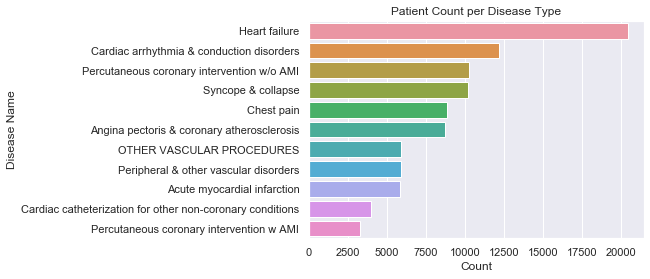

In [6]:
sns.set()
types = ['Normal Birth', 'Vaginal delivery', 'Cesarean delivery', 'Septicemia', 'Heart failure', 'Other pneumonia', 'Chronic obstructive pulmonary disease', 'Skin infections', 'Rehabilitation']
ax = sns.countplot(y = 'apr_drg_description', data = data_top10, order = data_top10['apr_drg_description'].value_counts().index, orient='h')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(ylabel='Disease Name', xlabel='Count', title='Patient Count per Disease Type')

In [16]:
death_list = []
for disease in data_top10["apr_drg_description"].unique():
    death_count = 0
    type_count = 0
    for i in range(len(data_top10)):
        if data_top10.iloc[i, 3] == disease and data_top10.iloc[i, 35] == 'Died':
            death_count += 1
    death_list.append(death_count)
   
type_list = []
for disease in data_top10["apr_drg_description"].unique():
    type_count = 0
    for i in range(len(data_top10)):
        if data_top10.iloc[i, 3] == disease :
            type_count += 1
    type_list.append(type_count)

In [17]:
death_rate = sorted(np.array(death_list)/np.array(type_list), reverse=True)

[Text(0, 0.5, 'Disease Name'),
 Text(0.5, 0, 'Death Rate'),
 Text(0.5, 1.0, 'Death Rate per Disease Type')]

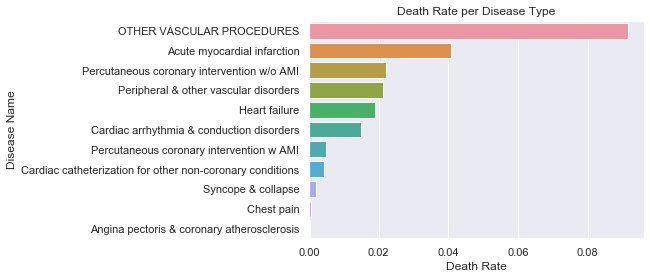

In [20]:
ax = sns.barplot(y=data_top10["apr_drg_description"].unique(), x=death_rate)
ax.set(ylabel='Disease Name', xlabel='Death Rate', title='Death Rate per Disease Type')

## total charges for circular disease

[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'total charges')]

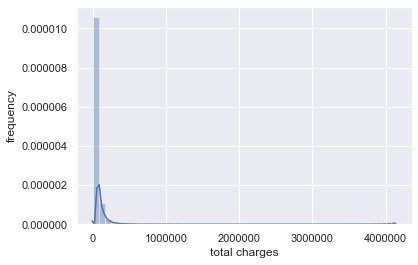

In [9]:
ax = sns.distplot(data_circular['total_charges'])
ax.set(xlabel='total charges', ylabel='frequency')

In [21]:
d_rate = pd.DataFrame(data=np.vstack((data_top10["apr_drg_description"].unique(), type_list, death_list)))
d_rate.rename(columns=d_rate.iloc[0]).drop(d_rate.index[0])

,OTHER VASCULAR PROCEDURES,Acute myocardial infarction,Percutaneous coronary intervention w/o AMI,Peripheral & other vascular disorders,Heart failure,Cardiac arrhythmia & conduction disorders,Percutaneous coronary intervention w AMI,Cardiac catheterization for other non-coronary conditions,Syncope & collapse,Chest pain,Angina pectoris & coronary atherosclerosis
1,5914,5862,10235,5889,20437,12210,3260,4001,10198,8885,8757
2,113,536,49,130,834,182,69,3,20,3,38


In [29]:
#results_no_miss = results_df.dropna()
heart = data_circular[data_circular['apr_drg_description'] == 'Heart failure']
cardiac = data_circular[data_circular['apr_drg_description'] == 'Cardiac arrhythmia & conduction disorders']
chest = data_circular[data_circular['apr_drg_description'] == 'Chest pain'] 

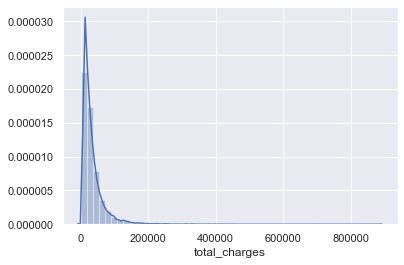

In [152]:
sns.distplot(heart['total_charges'])

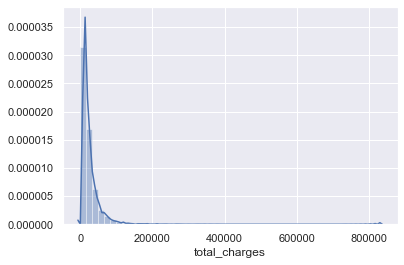

In [151]:
sns.distplot(cardiac['total_charges'])

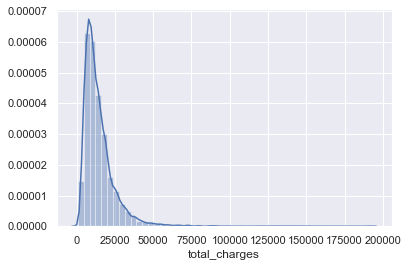

In [150]:
sns.distplot(chest['total_charges'])

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Patient Disposition'),
 Text(0.5, 1.0, 'Top 10 Patient Disposition Count')]

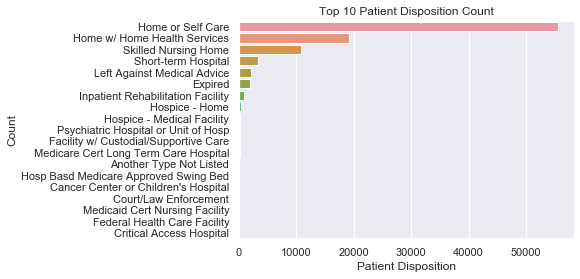

In [47]:
ax = sns.countplot(y = 'patient_disposition', data = data_top10, order = data_top10['patient_disposition'].value_counts().index)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(xlabel='Patient Disposition', ylabel='Count', title='Top 10 Patient Disposition Count')

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Length of Stay'),
 Text(0.5, 1.0, 'Top 10 Length of Stay Count')]

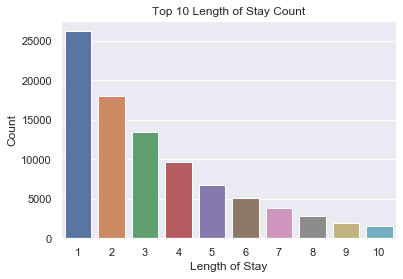

In [48]:
ax = sns.countplot(x = 'length_of_stay', data = data_top10, order = data_top10['length_of_stay'].value_counts()[:10].index)
ax.set(xlabel='Length of Stay', ylabel='Count', title='Top 10 Length of Stay Count')

In [17]:
corre = data_circular[['apr_drg_description', 'total_charges', 'length_of_stay', 'patient_disposition']]
corre['total_charges'] = corre['total_charges'].astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# add NY state map for hospital with number of patients for particular disease

## Data Preprocessing and Model Fitting

In [79]:
def bootstrap(X, y, model, metric):
    n_iterations = 100
    n_size = int(len(X) * 0.50)
    # run bootstrap
    stats = []
    for i in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
        #model = LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr').
        model.fit(X_train, y_train)
        # evaluate model
        #predictions = model.predict(X_test)
        score = model.score(X_test, y_test)
        stats.append(score)
    
    # plot scores
    plt.hist(stats)
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print(f'{alpha*100} confidence interval of {metric} is {lower} and {upper}')

In [80]:
def score_metrics(y_test, y_pred):
    precision, recall, fscore, support = score(y_test, y_pred)
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

### Linear Regression: Predict total cost

In [4]:
exclude_features = ['abortion_edit_indicator', 'birth_weight', 'apr_drg_code', 'apr_mdc_description',
'apr_mdc_code', 'facility_id', 'apr_severity_of_illness_description',
'ccs_diagnosis_description', 'ccs_procedure_description', 'operating_certificate_number', 
'zip_code_3_digits', 'source_of_payment_1', 'source_of_payment_2', 'source_of_payment_3', 'total_charges']

In [29]:
X = data_circular[data_circular.columns[~data_circular.columns.isin(exclude_features)]]
y = data_circular['total_charges']

In [30]:
le = LabelEncoder()
X = X.apply(le.fit_transform)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [8]:
cat = ['age_group', 'apr_drg_description', 'apr_medical_surgical_description',
       'apr_risk_of_mortality', 'apr_severity_of_illness_code',
       'ccs_diagnosis_code', 'ccs_procedure_code', 'discharge_year', 'emergency_department_indicator', 
        'ethnicity', 'facility_name', 'gender', 'hospital_county', 'hospital_service_area',]

In [32]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.coef_
reg.score(X_test, y_test), mean_absolute_error(y_test, reg.predict(X_test))

(0.7451931391452362, 18512.051419195)

In [206]:
pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)

,0,0
0,age_group,-3.947979e+03
1,apr_drg_description,-4.170218e+02
2,apr_medical_surgical_description,4.036508e+04
3,apr_risk_of_mortality,-2.037130e+03
4,apr_severity_of_illness_code,2.003699e+02
5,ccs_diagnosis_code,1.039419e+02
6,ccs_procedure_code,-1.193880e+01
7,discharge_year,-4.965841e-10
8,emergency_department_indicator,-5.459214e+03
9,ethnicity,2.962890e+02


## cross validation

In [11]:
np.mean(cross_val_score(reg, X, y, cv=10))

0.606945872249034

In [35]:
scores = []
reg = LinearRegression()
cv = KFold(n_splits=5, random_state=3, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index,], X.iloc[test_index,], y.iloc[train_index,], y.iloc[test_index,]
    reg.fit(X_train, y_train)
    scores.append(reg.score(X_test, y_test))
scores

[0.44507258159804863,
 0.6945705387517581,
 0.3315794939608686,
 0.7403943221091952,
 0.7640704951006816]

## bootstrap

95.0 confidence interval of coefficient of determination is 0.7035009855969174 and 0.7488262671531548


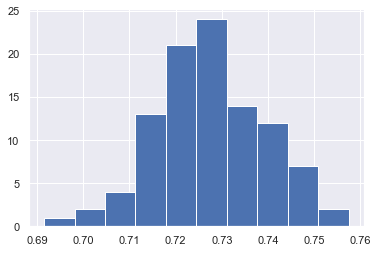

In [22]:
bootstrap(X, y, reg, 'coefficient of determination')

### Ridge regression and Ridge CV: Predict total cost

In [46]:
ridge = Ridge(alpha=10).fit(X_train, y_train) 
ridge.score(X_test, y_test), mean_absolute_error(y_test, ridge.predict(X_test))

(0.768203493881595, 17352.471408278547)

In [47]:
#cross-validation
np.mean(cross_val_score(ridge, X, y, cv=10))

0.6084874765630285

In [53]:
rd = RidgeCV(alphas=np.arange(1, 10)).fit(X_train, y_train)
rd.score(X_test, y_test)

0.7651878221485966

In [56]:
np.mean(cross_val_score(rd, X, y, cv=10))

0.6069683975378228

### Linear Regression: Predict length of stay

In [104]:
exclude_features_los = ['abortion_edit_indicator', 'birth_weight', 'apr_drg_code', 'apr_mdc_description',
'apr_mdc_code', 'facility_id', 'apr_severity_of_illness_description',
'ccs_diagnosis_description', 'ccs_procedure_description', 'operating_certificate_number', 
'zip_code_3_digits', 'source_of_payment_1', 'source_of_payment_2', 'source_of_payment_3', 'length_of_stay']

In [105]:
X = data_circular[data_circular.columns[~data_circular.columns.isin(exclude_features_los)]]
y = data_circular['length_of_stay']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [107]:
le = LabelEncoder()
X_train = X_train.apply(le.fit_transform)
X_test = X_test.apply(le.fit_transform)

In [108]:
reg_stay = LinearRegression().fit(X_train, y_train)
reg_stay.coef_
reg_stay.score(X_train, y_train), mean_absolute_error(y_test, reg_stay.predict(X_test))

(0.46195137308748924, 4.114830142904886)

### Logistic Regression : Predict patient disposition for circulatory disease overall

In [8]:
exclude_features_outcome = ['abortion_edit_indicator', 'birth_weight', 'apr_drg_code', 'apr_mdc_description',
'apr_mdc_code', 'facility_id', 'apr_severity_of_illness_description',
'ccs_diagnosis_description', 'ccs_procedure_description', 'operating_certificate_number', 
'zip_code_3_digits', 'source_of_payment_1', 'source_of_payment_2', 'source_of_payment_3', 'patient_disposition', 'expect_outcome']

In [18]:
X = data_circular[data_circular.columns[~data_circular.columns.isin(exclude_features_outcome)]]
y = data_circular['expect_outcome']

In [19]:
le = LabelEncoder()
X = X.apply(le.fit_transform)
y = le.fit_transform(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [21]:
#logistic regression
logit = LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr')
logit.fit(X_train, y_train)
logit.score(X_train, y_train)

0.79186519832129

In [140]:
accuracy_score(y_test, logit.predict(X_test))

0.7977197189616728

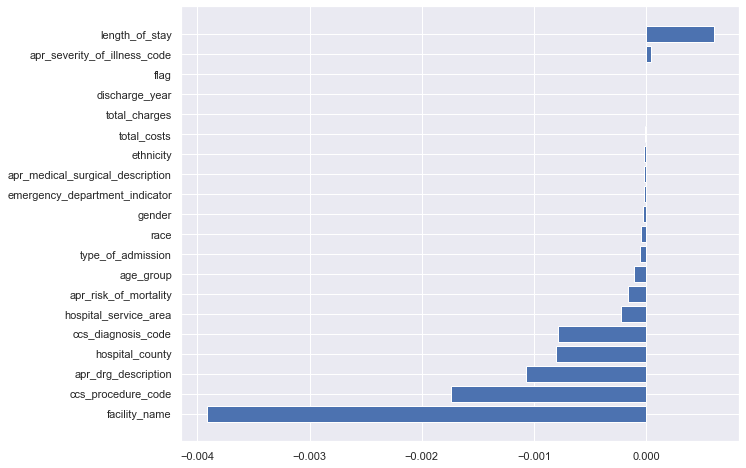

In [149]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(logit.coef_.ravel(), list(X_train.columns))

In [22]:
#cross validation
cv_logit = cross_val_score(LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr'), X, y, cv=10)
cv_logit

array([0.79301641, 0.79301641, 0.79301641, 0.79301641, 0.79301641,
       0.79301641, 0.79299899, 0.79299899, 0.79306572, 0.79319923])

In [23]:
print(f"Out of sample error for logistic regression with 10 fold cross-validation is {np.mean(cv_logit)}")

Out of sample error for logistic regression with 10 fold cross-validation is 0.7930361373692165


95.0 confidence interval of accuracy score is 0.7896875065738267 and 0.795728064455056


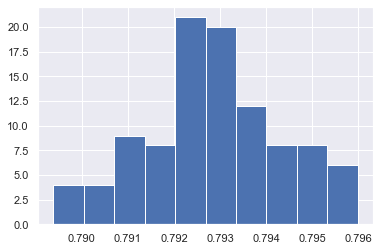

In [24]:
bootstrap(X, y, logit, 'accuracy score')

### Logistic Regression : Predict patient disposition for heart attack

In [26]:
exclude_features_outcome = ['abortion_edit_indicator', 'birth_weight', 'apr_drg_code', 'apr_mdc_description',
'apr_mdc_code', 'facility_id', 'apr_severity_of_illness_description',
'ccs_diagnosis_description', 'ccs_procedure_description', 'operating_certificate_number', 
'zip_code_3_digits', 'source_of_payment_1', 'source_of_payment_2', 'source_of_payment_3', 'patient_disposition', 'expect_outcome', 
'ccs_diagnosis_code', 'ccs_procedure_code', 'discharge_year', 'total_costs', 'apr_medical_surgical_description', 
'facility_name', 'hospital_county', 'hospital_service_area']

In [27]:
def process(data, columns, exclude, response):
    data_new = data[data['apr_drg_description'] == columns]
    X = data_new[data_new.columns[~data_new.columns.isin(exclude)]]
    y = data_new[response]
    le = LabelEncoder()
    X = X.apply(le.fit_transform)
    y = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    return X_train, X_test, y_train, y_test, X, y

In [42]:
X_train, X_test, y_train, y_test, X, y = process(data_circular, 'Heart failure', exclude_features_outcome, 'expect_outcome')
logit = LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr')
logit.fit(X_train, y_train)
logit.score(X_train, y_train)

0.7097681815401553

In [76]:
f1_score(y_test, logit.predict(X_test), average='weighted')

0.6019074387381979

In [41]:
cv_logit = cross_val_score(LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr'), X, y, cv=10)
np.mean(cv_logit)

0.711651030260863

95.0 confidence interval of accuracy score is 0.7006544342507645 and 0.715749235474006


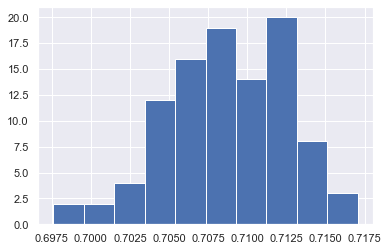

In [14]:
#old features and more features
bootstrap(X, y, logit, 'accuracy score')

In [221]:
score_metrics(y_test, logit.predict(X_test))

precision: [0.27906977 0.         0.72014833 0.         0.        ]
recall: [0.01323043 0.         0.99047943 0.         0.        ]
fscore: [0.02526316 0.         0.83395362 0.         0.        ]
support: [ 907  152 2941   77   11]


In [44]:
conf = confusion_matrix(y_test, logit.predict(X_test))

In [45]:
conf

array([[   0,    0,  907,    0,    0],
       [   0,    0,  152,    0,    0],
       [   0,    0, 2941,    0,    0],
       [   0,    0,   77,    0,    0],
       [   0,    0,   11,    0,    0]])

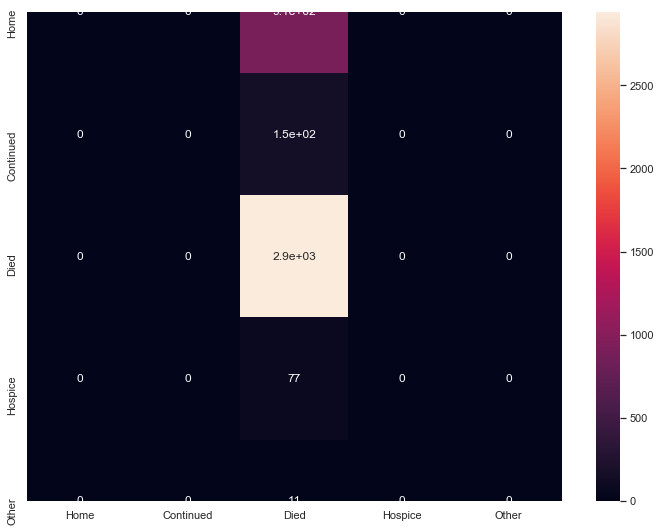

In [48]:
class_name = data_circular['expect_outcome'].unique()
df_cm = pd.DataFrame(conf, index = [i for i in class_name],
                  columns = [i for i in class_name])
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True)

In [128]:
#random forest
X_train, X_test, y_train, y_test, X, y = process(data_circular, 'Heart failure', exclude_features_outcome, 'expect_outcome')
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X, y)
clf.score(X_test, y_test)

0.7194227005870841

In [32]:
cv_xgb = cross_val_score(xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, random_state=42), X, y, cv=10)
np.mean(cv_xgb)

0.7141465711160684

In [77]:
# xgb boost
xgb_model = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, random_state=42)
xgb_model.fit(X_train, y_train)
accuracy_score(y_test, xgb_model.predict(X_test))

0.7216242661448141

In [75]:
f1_score(y_test, xgb_model.predict(X_test), average='weighted')

0.6145303799538747

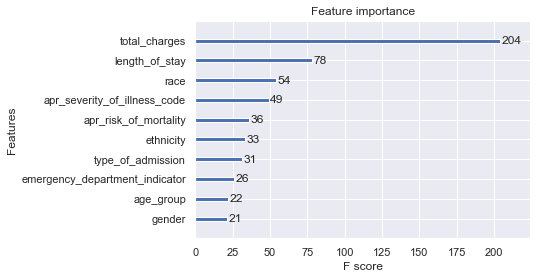

In [131]:
xgb.plot_importance(xgb_model)

95.0 confidence interval of accuracy score is 0.7071131498470948 and 0.721782874617737


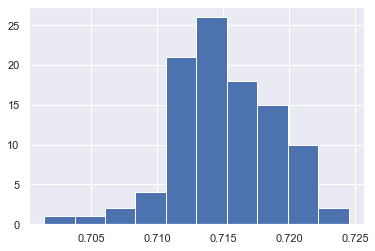

In [81]:
bootstrap(X, y, xgb_model, 'accuracy score')

# binary death/survive

In [36]:
data_heart = data_circular[data_circular['apr_drg_description'] == 'Heart failure']
data_death = data_heart.copy(deep=True)
for i in range(len(data_death)):
    if data_death.iloc[i, 35] != 'Died':
        data_death.iloc[i, 35] = 'Survived'

In [38]:
X = data_death[data_death.columns[~data_death.columns.isin(exclude_features_outcome)]]
y = data_death['expect_outcome']
le = LabelEncoder()
#mlb = MultiLabelBinarizer()
X = X.apply(le.fit_transform)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [41]:
xgb_model = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, random_state=42).fit(X_train, y_train)
accuracy_score(y_test, xgb_model.predict(X_test))

0.9628180039138943

In [39]:
logit = LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr').fit(X_train, y_train)
logit.score(X_train, y_train)

0.9582849103920729

In [194]:
cv_logit = cross_val_score(LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr'), X, y, cv=10)
np.mean(cv_logit)

0.959191754804608

In [196]:
y_pred = logit.predict(X_test)
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.       0.962818]
recall: [0. 1.]
fscore: [0.         0.98105683]


### Logistic Regression : Predict patient disposition for Cardiac arrhythmia & conduction disorders

In [87]:
X_train, X_test, y_train, y_test, X, y = process(data_circular, 'Cardiac arrhythmia & conduction disorders', exclude_features_outcome, 'expect_outcome')
logit = LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr')
logit.fit(X_train, y_train)
logit.score(X_train, y_train)

0.8098894348894349

In [210]:
cv_logit = cross_val_score(LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr'), X, y, cv=10)
np.mean(cv_logit)

0.8088487426045301

In [92]:
recall_score(y_test, logit.predict(X_test), average='weighted')

0.8173628173628174

95.0 confidence interval of accuracy score is 0.8023085585585585 and 0.8192158067158066


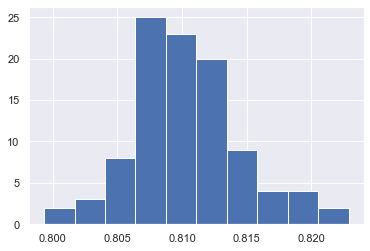

In [214]:
bootstrap(X, y, logit, 'accuracy score')

In [16]:
score_metrics(y_test, logit.predict(X_test))

precision: [0.5        0.         0.81870386 0.         0.        ]
recall: [0.00524934 0.         1.         0.         0.        ]
fscore: [0.01038961 0.         0.90031574 0.         0.        ]
support: [ 381   36 1996   13   16]


In [96]:
cv_logit = cross_val_score(xgb_model, X, y, cv=10)
np.mean(cv_logit)

0.8119590060531389

In [89]:
xgb_model = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, random_state=42)
xgb_model.fit(X_train, y_train)
accuracy_score(y_test, xgb_model.predict(X_test))

0.816953316953317

In [95]:
precision_score(y_test, xgb_model.predict(X_test), average='weighted')

0.668568602147938

95.0 confidence interval of accuracy score is 0.8047553235053235 and 0.8216830466830467


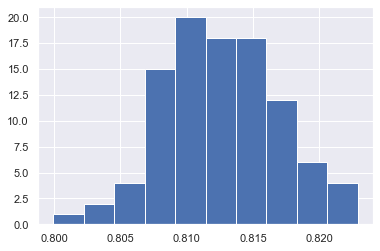

In [100]:
bootstrap(X, y, xgb_model, 'accuracy score')

# binary death/survive

In [28]:
death_cardiac = data_circular[data_circular['apr_drg_description'] == 'Cardiac arrhythmia & conduction disorders']
for i in range(len(death_cardiac)):
    if death_cardiac.iloc[i, 35] != 'Died':
        death_cardiac.iloc[i, 35] = 'Survived'

In [30]:
X = death_cardiac[death_cardiac.columns[~death_cardiac.columns.isin(exclude_features_outcome)]]
y = death_cardiac['expect_outcome']
le = LabelEncoder()
#mlb = MultiLabelBinarizer()
X = X.apply(le.fit_transform)
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [31]:
logit = LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr')
logit.fit(X_train, y_train)
logit.score(X_train, y_train)

0.985053235053235

In [32]:
cv_logit = cross_val_score(LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr'), X, y, cv=10)
np.mean(cv_logit)

0.9850943151815142

In [33]:
y_pred = logit.predict(X_test)
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.         0.98525799]
recall: [0. 1.]
fscore: [0.         0.99257426]


In [34]:
death_cardiac['expect_outcome'].value_counts()

Survived    12028
Died          182
Name: expect_outcome, dtype: int64

## Predicting Costs Incurred Case Study: Knee Replacement

In [10]:
def bootstrap_reg(X, y, model, metric):
    n_iterations = 100
    n_size = int(len(X) * 0.50)
    # run bootstrap
    stats = []
    for i in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
        #model = LogisticRegression(penalty='l2', random_state=0, solver='saga', multi_class='ovr').
        model.fit(X_train, y_train)
        # evaluate model
        #predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, model.predict(X_test))
        stats.append(mae)
    
    # plot scores
    plt.hist(stats)
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1000000, np.percentile(stats, p))
    print(f'{alpha*100} confidence interval of {metric} is {lower} and {upper}')

In [106]:
def process_reg(data, columns, exclude, response):
    data_new = data[data['apr_drg_description'] == columns]
    X = data_new[data_new.columns[~data_new.columns.isin(exclude)]]
    y = data_new[response]
    le = LabelEncoder()
    X = X.apply(le.fit_transform)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    return X_train, X_test, y_train, y_test, X, y

In [103]:
data_knee = data.loc[data['apr_drg_description'] == 'Knee joint replacement']
data_knee['source_of_payment_2'] = data_knee.source_of_payment_2.fillna('Covered')
data_knee['source_of_payment_3'] = data_knee.source_of_payment_2.fillna('Covered')
data_knee["total_charges"] = pd.to_numeric(data_knee["total_charges"])

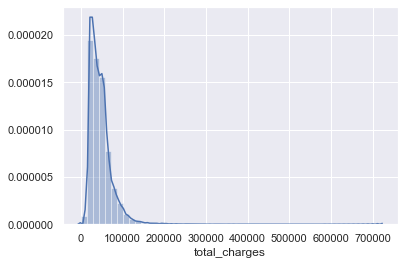

In [86]:
sns.distplot(data_knee['total_charges'])

In [104]:
exclude_features_cost = ['abortion_edit_indicator', 'birth_weight', 'apr_drg_code', 'apr_mdc_description',
'apr_mdc_code', 'facility_id', 'apr_severity_of_illness_description',
'ccs_diagnosis_description', 'ccs_procedure_description', 'operating_certificate_number', 
'zip_code_3_digits', 'ccs_diagnosis_code', 'ccs_procedure_code', 'discharge_year', 
'facility_name', 'hospital_county', 'hospital_service_area', 'total_charges']

In [137]:
X_train, X_test, y_train, y_test, X, y = process_reg(data_knee, 'Knee joint replacement', exclude_features_cost, 'total_charges')
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train) 
mean_absolute_error(y_test, ridge.predict(X_test)), mean_squared_error(y_test, ridge.predict(X_test))

(15925.29869545799, 588567720.0424662)

In [112]:
ridge.score(X_test, y_test)

0.2227503722270859

95.0 confidence interval of Mean Absolute Error is 15902.596513125216 and 16282.264389330736


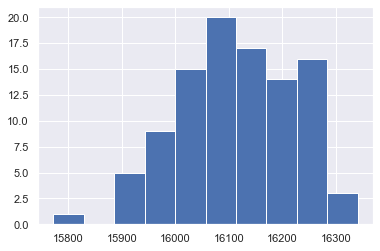

In [144]:
bootstrap_reg(X, y, ridge, 'Mean Absolute Error')

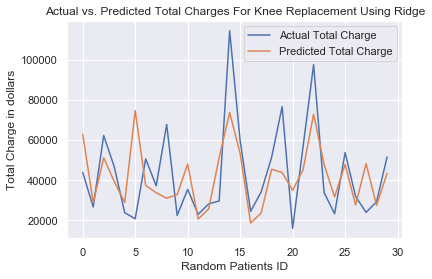

In [138]:
y_test = pd.to_numeric(y_test)
plt.subplot
plt.plot(np.arange(30), y_test[50:80], label = 'Actual Total Charge')
plt.plot(ridge.predict(X_test)[50:80], label = 'Predicted Total Charge')
plt.xlabel('Random Patients ID')
plt.ylabel('Total Charge in dollars')
plt.title('Actual vs. Predicted Total Charges For Knee Replacement Using Ridge')
plt.legend()

In [108]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train) 
mean_absolute_error(y_test, lasso.predict(X_test)), mean_squared_error(y_test, lasso.predict(X_test))

(15930.473094938174, 589360694.2230747)

In [113]:
lasso.score(X_test, y_test)

0.2217031879087428

In [133]:
##XGB boost
xgb_model = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, random_state=42).fit(X_train, y_train)
mean_absolute_error(y_test, xgb_model.predict(X_test))

[16:51:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


18229.92199389927

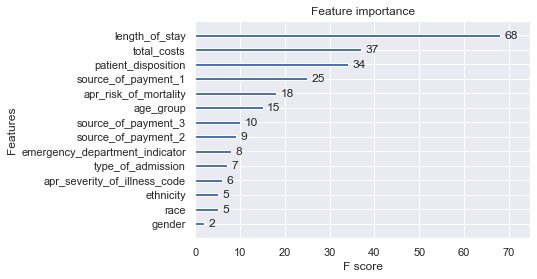

In [134]:
xgb.plot_importance(xgb_model)

## cost visulization by county knee

In [122]:
knee_county = data_knee.groupby('hospital_county', as_index=False)['total_charges'].mean()

In [123]:
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
df_sample_r = df_sample[df_sample['STNAME'] == 'New York']
fips = df_sample_r['FIPS'].tolist()
miss_c = ['Allegany', 'Delaware', 'Greene', 'Hamilton', 'Essex', 'Herkimer', 'Schoharie', 'Schuyler', 'Seneca', 'Tioga', 
          'Washington', 'Yates']
for i in miss_c:
    knee_county = knee_county.append({'hospital_county': i, 'total_charges': 0}, ignore_index=True)
knee_county = knee_county.sort_values(by=['hospital_county'])
knee_county['fips'] = fips

In [108]:
values = knee_county['total_charges'].tolist()
endpts = list(np.mgrid[min(values)+1000:max(values):4j])
colorscale = [  
    'rgb(195, 196, 222)',
    'rgb(63.0, 188.0, 115.0)',
    'rgb(38.0, 130.0, 142.0)',
    'rgb(66.0, 64.0, 134.0)',
    'rgb(68.0, 1.0, 84.0)'
]
fig = ff.create_choropleth(
    fips=knee_county['fips'], values=knee_county['total_charges'], scope=['New York'], show_state_data=True,
    colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
    plot_bgcolor='rgb(229,229,229)',
    paper_bgcolor='rgb(229,229,229)',
    legend_title='Total Charges for Knee Replacement by County',
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}
)
fig.layout.template = None
fig.show()

## Predicting Costs Incurred Case Study: Vaginal delivery

In [114]:
delivery = data.loc[data['apr_drg_description'] == 'Vaginal delivery']
delivery['source_of_payment_2'] = delivery.source_of_payment_2.fillna('Covered')
delivery['source_of_payment_3'] = delivery.source_of_payment_2.fillna('Covered')
delivery["total_charges"] = pd.to_numeric(delivery["total_charges"])

In [116]:
X_train, X_test, y_train, y_test, X, y = process_reg(delivery, 'Vaginal delivery', exclude_features_cost, 'total_charges')
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train) 
mean_absolute_error(y_test, ridge.predict(X_test)), mean_squared_error(y_test, ridge.predict(X_test)), ridge.score(X_test, y_test)

(4426.619046340606, 69359381.20029813, 0.18320264268330044)

95.0 confidence interval of Mean Absolute Error is 0.1789554335329644 and 0.21133660343104288


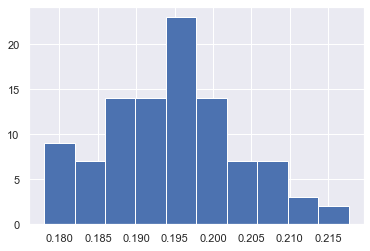

In [174]:
bootstrap(X, y, ridge, 'Mean Absolute Error')

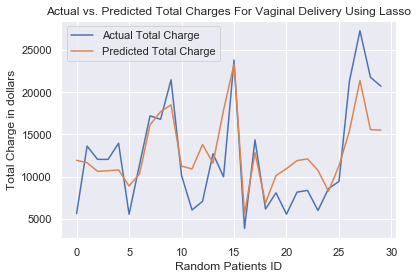

In [136]:
y_test = pd.to_numeric(y_test)
plt.subplot
plt.plot(np.arange(30), y_test[100:130], label = 'Actual Total Charge')
plt.plot(lasso.predict(X_test)[100:130], label = 'Predicted Total Charge')
plt.xlabel('Random Patients ID')
plt.ylabel('Total Charge in dollars')
plt.title('Actual vs. Predicted Total Charges For Vaginal Delivery Using Lasso')
plt.legend()

In [117]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train) 
mean_absolute_error(y_test, lasso.predict(X_test)), mean_squared_error(y_test, lasso.predict(X_test)), lasso.score(X_test, y_test)

(4426.61279990968, 69359011.75259961, 0.18320699341277058)

## cost visulization by county delivery

In [125]:
de_county = delivery.groupby('hospital_county', as_index=False)['total_charges'].mean()

In [126]:
miss_c = ['Greene', 'Hamilton', 'Essex', 'Herkimer','Orleans', 'Schoharie', 'Schuyler', 'Seneca', 'Tioga', 
          'Washington', 'Yates']
for i in miss_c:
    de_county = de_county.append({'hospital_county': i, 'total_charges': 0}, ignore_index=True)
de_county = de_county.sort_values(by=['hospital_county'])
de_county['fips'] = fips

In [133]:
values = de_county['total_charges'].tolist()
endpts = list(np.mgrid[min(values)+1000:max(values):4j])
colorscale = [  
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]
fig = ff.create_choropleth(
    fips=de_county['fips'], values=de_county['total_charges'], scope=['New York'], show_state_data=True,
    colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
    plot_bgcolor='rgb(229,229,229)',
    paper_bgcolor='rgb(229,229,229)',
    legend_title='Total Charges for Vaginal Delivery by County',
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}
)
fig.layout.template = None
fig.show()